In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import os
import time
import io
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns


def initialization(seed=42):
    keras.backend.clear_session()
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [2]:
from matplotlib import font_manager
my_font = font_manager.FontProperties(fname='../Fonts/SourceHanSerifSC-Medium.otf', size=14)

# 神经机器翻译的编码器-解码器模型 An Encoder-Decoder Network for Nerual Machine Translation

## 编码器和解码器 Encoder and Decoder

- **编码器**
    - 几个循环单元的堆叠, 每个单元接受接受输入序列的单个元素, 收集其信息并进行前向传播
    - 在问答系统中,输入序列是问题中所有单词的集合. 每个单词表示$X_i$, $i$ 表示该单词的顺序.
    - 普通的RNN中, 隐藏状态 $h_i$ 使用以下公式计算： 

        <img src="../images/other/16-5.png" width="500">
    - 编码器向量是模型的编码器部分产生的最终隐藏状态。该向量旨在封装所有输入元素的信息，以帮助解码器做出准确的预测。它充当模型解码器部分的初始隐藏状态。



- **解码器**
    - 使用前一个隐藏状态来计算下一个隐藏状态:$h_t=f(W^{hh}h_{t-1})$
    - 时间步 $t$ 的输出 $y_t$ 使用以下公式计算：$y_t=softmax(W^Sh_t)$

   <img src="../images/other/16-4.png" width="500">

1. 编码器和解码器都会接受输入, 其中解码器的输入会向后偏移一位, 以`<SOS>`令牌作为序列开始, 编码器以`<EOS>`令牌作为输入序列的结束.
2. 如上图所示, **英文句子在输入到编码器之前会被颠倒**。这确保了英语句子的开头将最后被馈送到编码器.
3. 每个单词最初都由其 ID 表示（例如，单词“milk”的 ID 为 288）。接下来，嵌入层返回词嵌入。这些词嵌入实际上是馈送到`编码器`（一个序列到向量网络，编码器会将这个句子（词嵌入）转换为单个向量表示）和`解码器`（一个向量到序列网络，解码这个向量成另一种语言的句子）。
4. 在每个步长,`编码器`会输出在词汇表中每个单词的分数, 使用`Softmax`归一化转换为概率, 最高的概率会被输出.
5. 在推理期间将以前的输出单词作为输入.
    <img src="../images/other/16-6.png" width="300">

仍有一些细节需要处理:
1. **对于不定长的序列**, 由于规则张量具有固定形状, 因此只能容纳相同长度的句子. 可以使用**掩码**处理此问题, 但是如果**长度截然不同**, 就无法像情感分析一样仅仅裁剪就可以.
    - 可以将句子分为相似长度的一组, 较短的序列使用填充确保一组中所有的句子都具有相同的长度.
        ```python
        tf.data.erxperimental.bucket_by_sequence_length()
        #  "I drink milk" --> <pad> <pad> <pad> milk drink I."
        ```
       
2. 忽略`<EOS>`令牌后的所有输出, 将其屏蔽.
3. 当输出词汇量很大时, 为每个可能的单词输出概率会非常慢, 因为需要进行大量的计算.
      - 使用`Sampled-softmax`训练方法来加速训练: 仅查看模型为正确单词和不正确单词随机样本的 `logits` , 然后仅基于这些 `logits` 计算损失的近似值。
        ```python
          # 训练时使用
          tf.nn.sampled_softmax_loss()
        ```
         推断时使用`softmax`函数, `Sampled-softmax`不能在推理时使用，因为它需要知道目标。
         
         详情: https://mp.weixin.qq.com/s/5Z3pAZNTuoyBjcnTkZmpPw

- **回顾LSTM**
 - <img src="../images/other/15-15.png" width="500">
 - `keras`中使用`keras.layers.LSTM()`实现长短期记忆网络.
```python
lstm, state_h, state_c = LSTM(, return_state=True)
# 返回：
# lstm：每个时间步的隐藏状态
# state_h：最后一个时间步的隐藏状态
# state_c：最后一个时间步的cell状态
```

###  TensorFlow Addons 示例

`TensorFlow Addons` 项目包括许多序列到序列工具，让您轻松构建生产就绪的编码器-解码器。
- `TrainingSampler` 是 `TensorFlow Addons` 中提供的几个采样器之一：它们的作用是在每一步告诉解码器它应该假装之前的输出的内容。
    - 在推理过程中，这应该是实际输出的令牌的嵌入.
    - 在训练期间，应该是之前目标标记的嵌入.
    
- 在实践中，从上一个时间步的目标嵌入开始训练, 然后逐渐转换到 使用上一步输出的实际令牌的嵌入 是一个好主意。 
- `ScheduledEmbeddingTrainingSampler`: 将在目标或实际输出使用一个概率值做随机选择，您可以在训练过程中逐渐改变的概率。

- 创建了一个基本的编码器-解码器模型，类似于下图所示的模型

   <img src="../images/other/16-4.png" width="500">

In [3]:
import tensorflow_addons as tfa

In [4]:
initialization(42)

vocab_size = 100
embed_size = 10

In [5]:
embeddings = keras.layers.Embedding(input_dim=vocab_size,
                                    output_dim=embed_size)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

In [6]:
# 编码器
encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
encoder_embeddings = embeddings(encoder_inputs)

encoder = keras.layers.LSTM(512, return_state=True)
# return_state=True: 获取其最终的隐藏状态并将它传递给解码器
# LSTM将返回两种隐藏状态:长期状态C_t, 短期状态h_t
encoder_output, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

# 解码器
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_embeddings = embeddings(decoder_inputs)

# 为什么使用 `keras.layers.LSTMCell`？
# - 在推理过程中，我们使用一步输出作为下一步输入
# - keras.layers.LSTMCell 处理整个时序输入中的一步
decoder_cell = keras.layers.LSTMCell(512)  # 一步或是一个单词
sampler = tfa.seq2seq.sampler.TrainingSampler()  # 采样器
output_layer = keras.layers.Dense(vocab_size)  # 一个词对应一个向量

decoder = tfa.seq2seq.basic_decoder.BasicDecoder(cell=decoder_cell,
                                                 sampler=sampler,
                                                 output_layer=output_layer)

final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings,
    initial_state=encoder_state,
    sequence_length=sequence_lengths)

y_proba = tf.nn.softmax(final_outputs.rnn_output)

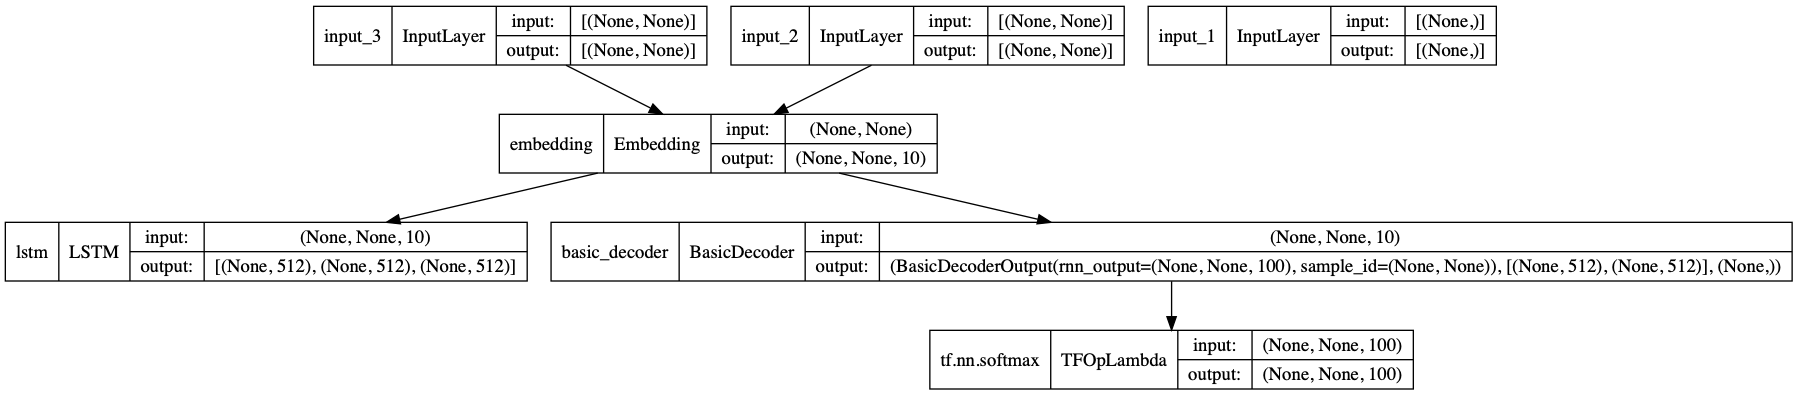

In [7]:
model = keras.Model(inputs=[encoder_inputs, decoder_inputs, sequence_lengths],
                    outputs=[y_proba])
keras.utils.plot_model(model,
                       "../models/plot_model/Encoder-Decoder_model_1.png",
                       show_shapes=True)

In [8]:
X = np.random.randint(100, size=10*1000).reshape(1000,10) # 10 words, batch_size=1000
y = np.random.randint(100, size=15*1000).reshape(1000,15) # 15 target words

# 解码器的输入会向后偏移一位
X_decoder = np.c_[np.zeros(shape=(1000,1)), y[:,:-1]]
# 固定每个句子的seq_lengths为15
seq_lengths = np.full(shape=[1000,], fill_value=15)

In [9]:
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer="adam")
history = model.fit([X, X_decoder, seq_lengths],y,
                    epochs=1)

2022-05-19 12:59:38.786756: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-19 12:59:43.471933: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


32/32 [==============================] - 8s 69ms/step - loss: 4.6052


## 编码器-解码器示例续

> 训练可以将日期字符串从一种格式转换为另一种格式的编码器-解码器模型
>
> 例如:从`April 22, 2019` 转换为 `2019-04-22`.

### 生成数据 Generate data

In [10]:
from datetime import datetime
from datetime import date

# date.fromordinal(): 返回对应于预期格列高利历序号的日期
dt = date.fromordinal(1)
dt, dt.strftime("%d, %Y"), dt.isoformat()

(datetime.date(1, 1, 1), '01, 1', '0001-01-01')

In [11]:
# date.toordinal(): 返回对应于公历格里高利序数的日期,其中第1年1月1日有序数1.
dt = datetime.now() # 获取当前日期时间
ordinal_dt = date.toordinal(dt)
dt, ordinal_dt

(datetime.datetime(2022, 5, 19, 12, 59, 49, 354767), 738294)

1. 随机生成日期, 并以输入格式和目标格式显示.

In [12]:
initialization(42)

In [13]:
MONTHS = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]

def random_dates(n_dates):
    min_date = date(1000,1,1).toordinal()
    max_date = date(9999,12,31).toordinal()
    
    ordinals = np.random.randint(low=min_date, high=max_date+1, size=n_dates)
    dates = [date.fromordinal(ordinal) for ordinal in ordinals]
    
    X = [MONTHS[date.month-1]+" "+date.strftime("%d, %Y") for date in dates]
    y = [date.isoformat() for date in dates]
    
    return X, y

In [14]:
random_dates(1)

(['September 20, 7075'], ['7075-09-20'])

In [15]:
n_dates = 5
X_example, y_example = random_dates(n_dates)

print("{:25s}{:25s}".format("输入", "目标"))
print("-" * 40)
for i in range(n_dates):
    print("{:25s}{:25s}".format(X_example[i], y_example[i]))

输入                       目标                       
----------------------------------------
May 15, 8579             8579-05-15               
January 11, 7103         7103-01-11               
June 01, 7451            7451-06-01               
July 29, 5634            5634-07-29               
November 27, 1301        1301-11-27               


2. 确定输入,目标的词汇(字符)表

In [16]:
# 输入字符表
input_chars = "".join(sorted(set("".join(MONTHS) + "0123456789, ")))
input_chars

' ,0123456789ADFJMNOSabceghilmnoprstuvy'

In [17]:
# 目标字符表
output_chars = "0123456789-"
output_chars

'0123456789-'

3. 编写函数将字符串转化为IDs形式

In [18]:
def date_str_to_ids(date_str, chars_list):
    return [chars_list.index(c) for c in date_str]

In [19]:
date_str_to_ids(X_example[0], chars_list=input_chars)

[16, 20, 37, 0, 3, 7, 1, 0, 10, 7, 9, 11]

In [20]:
date_str_to_ids(y_example[0], chars_list=output_chars)

[8, 5, 7, 9, 10, 0, 5, 10, 1, 5]

4. 处理可变长度的序列

    - `可变长度的输入序列`:
        - 可以**通过填充较短的序列**来处理，以便批次中的所有序列具有相同的长度，并**使用掩码来确保 RNN 忽略填充标记**。为了获得更好的性能，您可能还希望创建包含相似大小序列的批次。
        - **不规则张量可以保存可变长度的序列**.
          `tensorflow`中使用`ragged.constant()`将非矩形列表转为`tensor`类型
    
    - `可变长度输出序列`:
        - 如果预先知道输出序列的长度，那么您只需要配置损失函数，以便它忽略序列末尾之后的标记.同样，将使用模型的代码应该忽略序列末尾之外的标记。
        - 但是一般输出序列的长度是事先不知道的，所以解决的办法是**训练模型，使其在每个序列的末尾输出一个序列结束标记。**

In [21]:
def prepare_date_strs(date_strs, chars=input_chars):
    X_ids = [date_str_to_ids(date, chars) for date in date_strs]
    X = tf.ragged.constant(X_ids, ragged_rank=1)  # 转化为tensor类型
    return (X + 1).to_tensor()  # id从1开始


prepare_date_strs(X_example[0:4], input_chars)

<tf.Tensor: shape=(4, 16), dtype=int32, numpy=
array([[17, 21, 38,  1,  4,  8,  2,  1, 11,  8, 10, 12,  0,  0,  0,  0],
       [16, 21, 30, 36, 21, 33, 38,  1,  4,  4,  2,  1, 10,  4,  3,  6],
       [16, 36, 30, 24,  1,  3,  4,  2,  1, 10,  7,  8,  4,  0,  0,  0],
       [16, 36, 28, 38,  1,  5, 12,  2,  1,  8,  9,  6,  7,  0,  0,  0]],
      dtype=int32)>

In [22]:
def create_dataset(n_dates):
    X, y = random_dates(n_dates)
    X_pre = prepare_date_strs(X, input_chars)
    y_pre = prepare_date_strs(y, output_chars)
    return X_pre, y_pre

In [23]:
initialization(42)

X_train, y_train = create_dataset(10000)
X_val, y_val = create_dataset(2000)
X_test, y_test = create_dataset(2000)

X_train[1], y_train[0]

(<tf.Tensor: shape=(18,), dtype=int32, numpy=
 array([17, 21, 38,  1,  4,  8,  2,  1, 11,  8, 10, 12,  0,  0,  0,  0,  0,
         0], dtype=int32)>,
 <tf.Tensor: shape=(10,), dtype=int32, numpy=array([ 8,  1,  8,  6, 11,  1, 10, 11,  3,  1], dtype=int32)>)

In [24]:
X_train.shape

TensorShape([10000, 18])

### V1: 基础的seq2seq模型 First version: a very basic seq2seq model

1. 让我们首先尝试最简单的模型：我们输入输入序列，它首先通过`编码器`（一个嵌入层，然后是单个 `LSTM` 层），输出一个向量，然后通过`解码器`（单个 `LSTM` 层，后面是一个密集的输出层），它输出一个向量序列，每个向量代表所有可能的输出字符的估计概率。

    由于`解码器`期望一个序列作为输入，我们将向量（由`编码器`输出）重复尽可能多的最长输出序列。

In [25]:
initialization(seed=42)

In [26]:
embedding_size = 32
max_output_length = y_train.shape[1]

encoder = keras.models.Sequential([
    keras.layers.Embedding(
        input_dim=len(input_chars) + 1,  # id从1开始
        output_dim=embedding_size,
        input_shape=[None]),
    keras.layers.LSTM(128)
])

decoder = keras.models.Sequential([
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.Dense(len(output_chars) + 1, activation="softmax")
])

model = keras.models.Sequential([
    encoder, 
    keras.layers.RepeatVector(n=max_output_length),  # RepeatVector: 将输入重复n次
     decoder
])

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 128)               83680     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 128)           0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 10, 12)            133132    
Total params: 216,812
Trainable params: 216,812
Non-trainable params: 0
_________________________________________________________________


In [28]:
optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    validation_data=(X_val, y_val))

Epoch 1/20
313/313 [==============================] - 8s 13ms/step - loss: 1.8254 - accuracy: 0.3458 - val_loss: 1.3844 - val_accuracy: 0.4841
Epoch 2/20
313/313 [==============================] - 3s 11ms/step - loss: 1.2742 - accuracy: 0.5410 - val_loss: 1.1432 - val_accuracy: 0.5777
Epoch 3/20
313/313 [==============================] - 4s 11ms/step - loss: 0.9748 - accuracy: 0.6484 - val_loss: 0.8784 - val_accuracy: 0.6762
Epoch 4/20
313/313 [==============================] - 3s 11ms/step - loss: 0.9735 - accuracy: 0.6607 - val_loss: 1.0531 - val_accuracy: 0.6373
Epoch 5/20
313/313 [==============================] - 4s 12ms/step - loss: 0.7215 - accuracy: 0.7343 - val_loss: 0.5903 - val_accuracy: 0.7732
Epoch 6/20
313/313 [==============================] - 4s 12ms/step - loss: 0.5217 - accuracy: 0.8010 - val_loss: 1.4945 - val_accuracy: 0.4933
Epoch 7/20
313/313 [==============================] - 3s 11ms/step - loss: 0.3866 - accuracy: 0.8482 - val_loss: 0.3131 - val_accuracy: 0.8770

2. 编写函数将IDs转化为字符串形式

In [29]:
" "+input_chars

'  ,0123456789ADFJMNOSabceghilmnoprstuvy'

In [30]:
def ids_to_date_strs(ids, chars_list):
    return [
        "".join([(" " + chars_list)[index] for index in sequence])
        for sequence in ids
    ]

In [31]:
# 由于ragged.constant() 动态的使用0填充 将非矩形列表转为tensor类型
# [0] -> " "
ids_to_date_strs(X_train[:5], input_chars)

['September 20, 7075',
 'May 15, 8579      ',
 'January 11, 7103  ',
 'June 01, 7451     ',
 'July 29, 5634     ']

3. 测试模型

In [32]:
X_new = prepare_date_strs(["September 17, 2009", "July 14, 1789"])

# OR ids = model.predict_classes(X_new)       12<==since len("1789-07-14")
# model.predict(X_new).shape : (2, 10, 12) <==10<==since len("0123456789-")
ids = np.argmax(model.predict(X_new), axis=-1)
for date_str in ids_to_date_strs(ids, output_chars):
    print(date_str)

2009-09-17
1789-07-14


但是，由于该模型仅针对长度为 18 的输入字符串（即最长日期的长度）进行了训练，因此如果我们尝试使用它来对较短的序列进行预测，则它的性能并不好：

In [33]:
X_new = prepare_date_strs(["May 19, 2022", "July 14, 1789"])
#ids = model.predict_classes(X_new)
ids = np.argmax(model.predict(X_new), axis=-1)
for date_str in ids_to_date_strs(ids, output_chars):
    print(date_str)

2022-09-19
1789-01-14


4. 预处理输入序列 
    
    我们需要确保始终传递与训练期间相同长度的序列，必要时使用填充.强制进行0填充至`length==18(max)`
    ```python
# tf.pad()：填充函数
# mode :  "CONSTANT"(填充0), "REFLECT",  "SYMMETRIC" 
tf.pad(
    tensor, paddings, mode='CONSTANT', constant_values=0, name=None
)


In [34]:
t = [[2, 3, 4], [5, 6, 7]]
tf.pad(t, [[1, 1], [2, 3]])

<tf.Tensor: shape=(4, 8), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 2, 3, 4, 0, 0, 0],
       [0, 0, 5, 6, 7, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>

- `[1，1]`是在`pad`里是第一个，代表第一维即矩阵的行，左边的1代表上方放一行0，右边的1代表下方放一行0

- 同理，`[2,2]`顺序是第二个，代表对列操作，左边的2代表在左边放两列0，右边2代表在右边放两列0

In [35]:
max_input_length = X_train.shape[1]  # 18

# 预处理序列 -> 强制进行0填充至length==18(max)
def prepare_date_strs_padded(date_strs):
    X = prepare_date_strs(date_strs, input_chars)

    if X.shape[1] < max_input_length:
        X = tf.pad(X, [
            [0,0],
            [0, max_input_length-X.shape[1]]  
        ])
    return X

In [36]:
X_example[0:4]

['May 15, 8579', 'January 11, 7103', 'June 01, 7451', 'July 29, 5634']

In [37]:
prepare_date_strs_padded(X_example[0:4])

<tf.Tensor: shape=(4, 18), dtype=int32, numpy=
array([[17, 21, 38,  1,  4,  8,  2,  1, 11,  8, 10, 12,  0,  0,  0,  0,
         0,  0],
       [16, 21, 30, 36, 21, 33, 38,  1,  4,  4,  2,  1, 10,  4,  3,  6,
         0,  0],
       [16, 36, 30, 24,  1,  3,  4,  2,  1, 10,  7,  8,  4,  0,  0,  0,
         0,  0],
       [16, 36, 28, 38,  1,  5, 12,  2,  1,  8,  9,  6,  7,  0,  0,  0,
         0,  0]], dtype=int32)>

5. 再次进行测试模型

In [38]:
def convert_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    ids = np.argmax(model.predict(X), axis=-1)
    return ids_to_date_strs(ids, output_chars)

In [39]:
X_new = ["May 19, 2022", "July 14, 1789"]
convert_date_strs(X_new)

['2022-05-19', '1789-07-14']

### V2: 将移位的目标馈送到解码器（teacher forcing） Second version: feeding the shifted targets to the decoder (teacher forcing)

我们可以向解码器提供目标序列，而不是向解码器提供编码器输出向量的简单重复，向右移动一个时间步长。这样，在每个时间步，解码器都会知道前一个目标字符是什么。这应该有助于解决更复杂的序列到序列问题。

由于每个目标序列的第一个输出字符没有前一个字符，我们需要一个新的标记来表示序列的开始`sos`.


在推理过程中，我们不知道目标，那么我们将向解码器提供什么？我们可以一次只预测一个字符，从一个 `sos` 标记开始，然后将到目前为止预测的所有字符提供给解码器。


但是如果解码器的 `LSTM` 期望在每一步都获得前一个目标作为输入，我们应该如何将编码器输出的向量传递给它呢？好吧，一种选择是忽略输出向量，而是使用编码器的 `LSTM 状态`作为解码器的 `LSTM` 的初始状态（这要求编码器的 LSTM 必须具有与解码器的 LSTM 相同的单元数）。


现在让我们创建解码器的输入（用于训练、验证和测试）。`sos` 标记将使用最后一个可能的输出字符的 ID + 1 表示。

1. 将移位的目标馈送到解码器
    - 向右移动了一个时间步。这样，在每个时间步，解码器都会知道前一个目标字符是什么。这应该有助于解决更复杂的序列到序列问题。
    - 由于每个目标序列的第一个输出字符没有前一个字符，我们需要一个新的标记来表示序列的开始 `<sos>`。

In [40]:
sos_id = len(output_chars) + 1  # 11+1=12


def shift_output_sequences(y):
    sos_token = tf.fill(dims=(len(y), 1), value=sos_id)
    decoder = tf.concat([sos_token, y[:, :-1]], axis=1)
    return decoder

In [41]:
X_train_decoder = shift_output_sequences(y_train)
X_val_decoder = shift_output_sequences(y_val)
X_test_decoder = shift_output_sequences(y_test)

In [42]:
y_train[:5]

<tf.Tensor: shape=(5, 10), dtype=int32, numpy=
array([[ 8,  1,  8,  6, 11,  1, 10, 11,  3,  1],
       [ 9,  6,  8, 10, 11,  1,  6, 11,  2,  6],
       [ 8,  2,  1,  4, 11,  1,  2, 11,  2,  2],
       [ 8,  5,  6,  2, 11,  1,  7, 11,  1,  2],
       [ 6,  7,  4,  5, 11,  1,  8, 11,  3, 10]], dtype=int32)>

In [43]:
X_train_decoder[:5]

<tf.Tensor: shape=(5, 10), dtype=int32, numpy=
array([[12,  8,  1,  8,  6, 11,  1, 10, 11,  3],
       [12,  9,  6,  8, 10, 11,  1,  6, 11,  2],
       [12,  8,  2,  1,  4, 11,  1,  2, 11,  2],
       [12,  8,  5,  6,  2, 11,  1,  7, 11,  1],
       [12,  6,  7,  4,  5, 11,  1,  8, 11,  3]], dtype=int32)>

2. 构建,训练模型

In [44]:
initialization(42)

encoder_inputs_dim = len(input_chars) + 1  # +1: id从1开始,   # 39
decoder_inputs_dim = len(output_chars) + 2  # +2: ~, <sos>  # 13
decoder_outputs_dim = len(output_chars) + 1  # +1: ~, 无需预测<sos>  #12
embed_size = 32
units = 128

# sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

In [45]:
# 编码器
encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)  # 18
encoder_embedding_layer = keras.layers.Embedding(input_dim=encoder_inputs_dim,
                                                 output_dim=embed_size)
encoder_embeddings = encoder_embedding_layer(encoder_inputs)

encoder = keras.layers.LSTM(units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

# 解码器
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)  # 10
decoder_embedding_layer = keras.layers.Embedding(input_dim=decoder_inputs_dim,
                                                 output_dim=embed_size)
decoder_embeddings = decoder_embedding_layer(decoder_inputs)

decoder_lstm_layer = keras.layers.LSTM(units, return_sequences=True)
decoder_lstm_output = decoder_lstm_layer(decoder_embeddings,
                                         initial_state=encoder_state)
decoder_outputs = keras.layers.Dense(decoder_outputs_dim,
                                     activation="softmax")(decoder_lstm_output)

model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs],
                           outputs=[decoder_outputs])

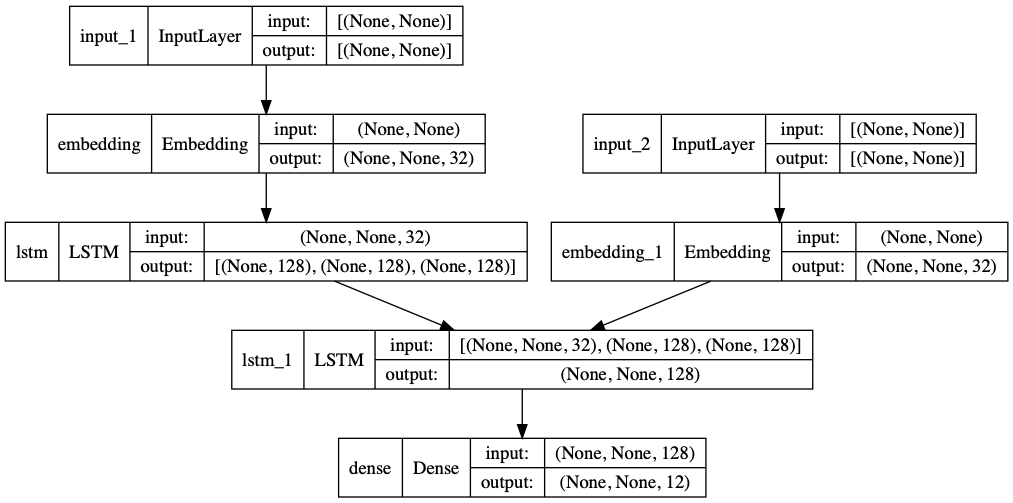

In [52]:
keras.utils.plot_model(model,
                       "../models/plot_model/Encoder-Decoder_model_4.png",
                       show_shapes=True)

In [47]:
optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit([X_train, X_train_decoder],
                    y_train,
                    epochs=10,
                    validation_data=([X_val, X_val_decoder], y_val))

Epoch 1/10
313/313 [==============================] - 8s 14ms/step - loss: 1.6803 - accuracy: 0.3742 - val_loss: 1.4177 - val_accuracy: 0.4503
Epoch 2/10
313/313 [==============================] - 3s 11ms/step - loss: 1.1901 - accuracy: 0.5584 - val_loss: 0.8955 - val_accuracy: 0.6709
Epoch 3/10
313/313 [==============================] - 4s 12ms/step - loss: 0.6278 - accuracy: 0.7760 - val_loss: 0.3910 - val_accuracy: 0.8706
Epoch 4/10
313/313 [==============================] - 4s 11ms/step - loss: 0.2436 - accuracy: 0.9391 - val_loss: 0.1390 - val_accuracy: 0.9750
Epoch 5/10
313/313 [==============================] - 4s 11ms/step - loss: 0.0731 - accuracy: 0.9926 - val_loss: 0.0441 - val_accuracy: 0.9977
Epoch 6/10
313/313 [==============================] - 4s 12ms/step - loss: 0.0401 - accuracy: 0.9964 - val_loss: 0.0255 - val_accuracy: 0.9990
Epoch 7/10
313/313 [==============================] - 3s 11ms/step - loss: 0.0168 - accuracy: 0.9998 - val_loss: 0.0137 - val_accuracy: 0.9999

这个模型也达到了 100% 的验证准确率，但它的速度更快。

3. 使用模型进行预测

    模型在验证集上达到了近100%的准确度！在推理过程中，模型中的解码器**将使用先前的预测进行当前预测.**
   

In [48]:
max_output_length = y_train.shape[1]  # 10


# 详解:预测日期字符串函数
def pred_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    print("X\n", X, "\n", "-" * 50)

    y_pred_ids = tf.fill(dims=(len(X), 1), value=sos_id)  # 初始位置:<sos>
    print("y:初始<sos>\n", y_pred_ids, "\n", "-" * 50)
    for index in range(max_output_length):
        pad_size = max_output_length - y_pred_ids.shape[1]  # 1: 10-1
        X_decoder = tf.pad(y_pred_ids, [[0, 0], [0, pad_size]])
        print("X_decoder:第%s轮\n" % (index + 1), X_decoder, "\n", "-" * 50)

        # 计算目标字符表的字符概率 并输出最大的ids
        y_probas_next = model.predict([X, X_decoder])[:, index:index + 1]
        y_pred_next = tf.argmax(y_probas_next, axis=-1, output_type=tf.int32)
        # 循环将预测字符上一个字符串进行拼接
        y_pred_ids = tf.concat([y_pred_ids, y_pred_next], axis=1)

    # 排除<sos>
    y_pred_str = ids_to_date_strs(y_pred_ids[:, 1:], output_chars)

    return y_pred_str


pred_date_strs(["July 14, 1789", "May 19, 2022"])

X
 tf.Tensor(
[[16 36 28 38  1  4  7  2  1  4 10 11 12  0  0  0  0  0]
 [17 21 38  1  4 12  2  1  5  3  5  5  0  0  0  0  0  0]], shape=(2, 18), dtype=int32) 
 --------------------------------------------------
y:初始<sos>
 tf.Tensor(
[[12]
 [12]], shape=(2, 1), dtype=int32) 
 --------------------------------------------------
X_decoder:第1轮
 tf.Tensor(
[[12  0  0  0  0  0  0  0  0  0]
 [12  0  0  0  0  0  0  0  0  0]], shape=(2, 10), dtype=int32) 
 --------------------------------------------------
X_decoder:第2轮
 tf.Tensor(
[[12  2  0  0  0  0  0  0  0  0]
 [12  3  0  0  0  0  0  0  0  0]], shape=(2, 10), dtype=int32) 
 --------------------------------------------------
X_decoder:第3轮
 tf.Tensor(
[[12  2  8  0  0  0  0  0  0  0]
 [12  3  1  0  0  0  0  0  0  0]], shape=(2, 10), dtype=int32) 
 --------------------------------------------------
X_decoder:第4轮
 tf.Tensor(
[[12  2  8  9  0  0  0  0  0  0]
 [12  3  1  3  0  0  0  0  0  0]], shape=(2, 10), dtype=int32) 
 ------------------------

['1789-07-14', '2022-05-19']

### V3: 使用 TF-Addons 的 seq2seq 实现 Third version: using TF-Addons's seq2seq implementation

让我们构建完全相同的模型，但使用 `TF-Addon` 的 `seq2seq API`。为了简单起见，没有模型输入来指定输出序列长度（但如果您的项目需要它，当输出序列有非常不同的长度,您可以轻松地将其添加回来）。

#### TrainingSampler采样器

1. 使用`tfa.seq2seq.seq2seq`的 `TrainingSampler`采样器的实现
    - `TrainingSampler`采样器:一个简单地读取其输入的训练采样器。


In [49]:
import tensorflow_addons as tfa

In [50]:
initialization(42)

encoder_inputs_dim = len(input_chars) + 1  # +1: id从1开始,   # 39
decoder_inputs_dim = len(output_chars) + 2  # +2: ~, <sos>  # 13
decoder_outputs_dim = len(output_chars) + 1  # +1: ~, 无需预测<sos>  #12
embed_size = 32
units = 128

# sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

In [51]:
# 编码器
encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)  # 18
encoder_embedding_layer = keras.layers.Embedding(input_dim=encoder_inputs_dim,
                                                 output_dim=embed_size)
encoder_embeddings = encoder_embedding_layer(encoder_inputs)

encoder = keras.layers.LSTM(units, return_state=True)
encoder_output, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

# 解码器
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)  # 10
decoder_embedding_layer = keras.layers.Embedding(input_dim=decoder_inputs_dim,
                                                 output_dim=embed_size)
decoder_embeddings = decoder_embedding_layer(decoder_inputs)

#############
decoder_cell = keras.layers.LSTMCell(units)
sampler = tfa.seq2seq.sampler.TrainingSampler()  # 采样器
output_layer = keras.layers.Dense(decoder_outputs_dim)

decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell, sampler,
                                                 output_layer)
#############

final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings,
    initial_state=encoder_state,
    #     sequence_length=sequence_lengths
)

y_proba = keras.layers.Softmax()(final_outputs.rnn_output)

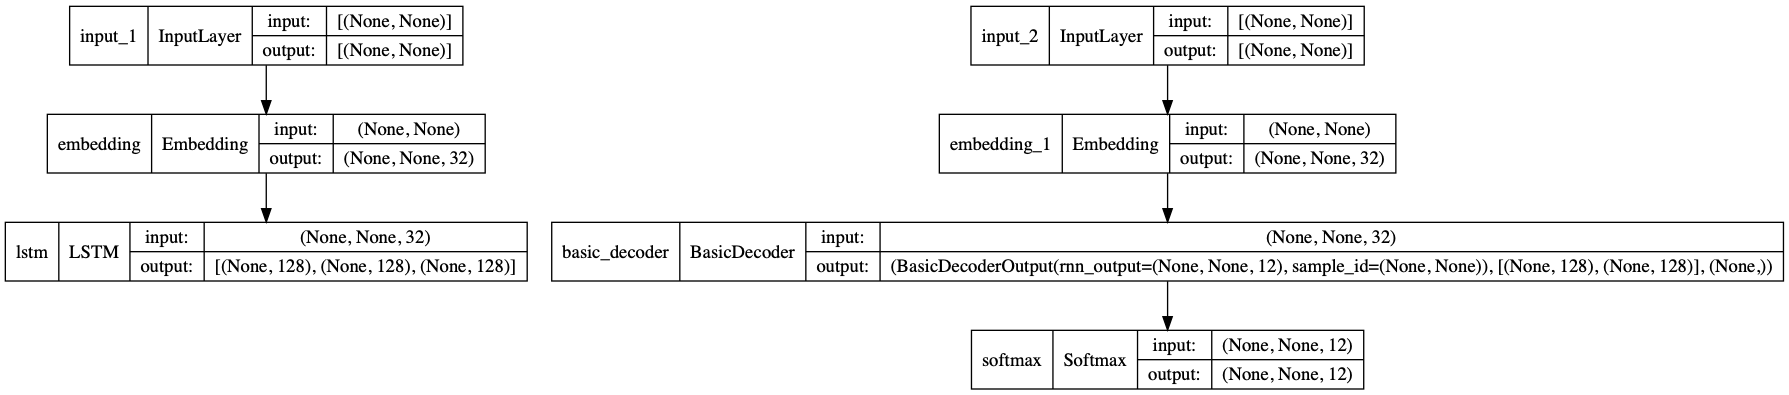

In [62]:
model = keras.Model(inputs=[encoder_inputs, decoder_inputs],
                    outputs=[y_proba])
keras.utils.plot_model(model,
                       "../models/plot_model/Encoder-Decoder_model_2.png",
                       show_shapes=True)

In [53]:
optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit([X_train, X_train_decoder],
                    y_train,
                    epochs=15,
                    validation_data=([X_val, X_val_decoder], y_val))

Epoch 1/15
313/313 [==============================] - 20s 50ms/step - loss: 1.6803 - accuracy: 0.3742 - val_loss: 1.4238 - val_accuracy: 0.4456
Epoch 2/15
313/313 [==============================] - 17s 54ms/step - loss: 1.1932 - accuracy: 0.5572 - val_loss: 0.9097 - val_accuracy: 0.6658
Epoch 3/15
313/313 [==============================] - 15s 47ms/step - loss: 0.6397 - accuracy: 0.7712 - val_loss: 0.3555 - val_accuracy: 0.8935
Epoch 4/15
313/313 [==============================] - 17s 53ms/step - loss: 0.2113 - accuracy: 0.9499 - val_loss: 0.1152 - val_accuracy: 0.9796
Epoch 5/15
313/313 [==============================] - 16s 50ms/step - loss: 0.1017 - accuracy: 0.9824 - val_loss: 0.0536 - val_accuracy: 0.9959
Epoch 6/15
313/313 [==============================] - 15s 48ms/step - loss: 0.0332 - accuracy: 0.9989 - val_loss: 0.0248 - val_accuracy: 0.9992
Epoch 7/15
313/313 [==============================] - 18s 56ms/step - loss: 0.0177 - accuracy: 0.9996 - val_loss: 0.0147 - val_accuracy:

2. 编写函数将IDs转化为字符串形式

In [54]:
" "+input_chars

'  ,0123456789ADFJMNOSabceghilmnoprstuvy'

In [55]:
def ids_to_date_strs(ids, chars_list):
    return [
        "".join([(" " + chars_list)[index] for index in sequence])
        for sequence in ids
    ]

3. 预处理序列 
    
    强制进行0填充至`length==18(max)`

In [56]:
max_input_length = X_train.shape[1]  # 18

# 预处理序列 -> 强制进行0填充至length==18(max)
def prepare_date_strs_padded(date_strs):
    X = prepare_date_strs(date_strs, input_chars)

    if X.shape[1] < max_input_length:
        X = tf.pad(X, [
            [0,0],
            [0, max_input_length-X.shape[1]]  
        ])
    return X

4. 使用模型进行预测

    模型在验证集上达到了近100%的准确度！在推理过程中，模型中的解码器**将使用先前的预测进行当前预测.**
   

In [57]:
max_output_length = y_train.shape[1]  # 10


# 预测日期字符串函数
def pred_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    y_pred_ids = tf.fill(dims=(len(X), 1), value=sos_id)  # 初始位置:<sos>

    for index in range(max_output_length):
        pad_size = max_output_length - y_pred_ids.shape[1]  # 1: 10-1
        X_decoder = tf.pad(y_pred_ids, [[0, 0], [0, pad_size]])
        # 计算目标字符表的字符概率 并输出最大的ids
        y_probas_next = model.predict([X, X_decoder])[:, index:index + 1]
        y_pred_next = tf.argmax(y_probas_next, axis=-1, output_type=tf.int32)
        # 循环将预测字符上一个字符串进行拼接
        y_pred_ids = tf.concat([y_pred_ids, y_pred_next], axis=1)

    # 排除<sos>
    y_pred_str = ids_to_date_strs(y_pred_ids[:, 1:], output_chars)

    return y_pred_str


pred_date_strs(["July 14, 1789", "May 19, 2022"])

['1789-07-14', '2022-05-19']

#### GreedyEmbeddingSampler采样器

到目前为止，在推理过程中，我们为每个新字符运行了一次模型.

- 使用更有效的**推理**方式:
   - 基于先前训练的层创建一个新的解码器，但使用`GreedyEmbeddingSampler`而不是`TrainingSampler`。
   - 在每个时间步长，`GreedyEmbeddingSampler`**将计算解码器输出的`argmax`**，并通过解码器的嵌入层运行生成的令牌`ids`。然后它将在下一个时间步长将生成的嵌入馈送到解码器的 `LSTM` 单元。这样，我们**只需要运行一次解码器**就可以得到完整的预测。

In [58]:
initialization(42)

encoder_inputs_dim = len(input_chars) + 1  # +1: id从1开始,   # 39
decoder_inputs_dim = len(output_chars) + 2  # +2: ~, <sos>  # 13
decoder_outputs_dim = len(output_chars) + 1  # +1: ~, 无需预测<sos>  #12
embed_size = 32
units = 128

- 几点注意事项：
    1. `GreedyEmbeddingSampler` 需要
        - `start_token`:包含每个解码器序列的 `start-of-sequence` ID 的向量.
        - `end_token`:一旦模型输出此`token`，解码器将停止解码序列.
    2. 我们必须在创建`BasicDecoder`时设置`maximum_iterations`，否则它可能会陷入无限循环（如果模型从未为至少一个序列输出结束标记）。这将迫使您重新启动 Jupyter 内核。
    3. **不再需要解码器输入，因为所有解码器输入都是根据前一个时间步的输出动态生成的**。
    4. 模型的输出是 `final_outputs.sample_id`，而不是 `final_outputs.rnn_outputs` 的 `softmax`。这使我们可以直接获得模型输出的 `argmax`。
        - 如果您更喜欢访问 `logits`，您可以将 `final_outputs.sample_id` 替换为 `final_outputs.rnn_outputs`。

In [59]:
max_output_length = y_train.shape[1]  # 10

# 解码器
# !!推理阶段不再需要解码器输入!!
# decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)  # 10
# decoder_embedding_layer = keras.layers.Embedding(input_dim=decoder_inputs_dim,
#                                                  output_dim=embed_size)
# decoder_embeddings = decoder_embedding_layer(decoder_inputs)

##############
# decoder_cell = keras.layers.LSTMCell(units)
# 贪婪采样器:从输出分布中获取最大值的推理采样器
inference_sampler = tfa.seq2seq.sampler.GreedyEmbeddingSampler(
    embedding_fn=decoder_embedding_layer)
# output_layer = keras.layers.Dense(decoder_outputs_dim)

inference_decoder = tfa.seq2seq.basic_decoder.BasicDecoder(
    cell=decoder_cell,          # 注意!!
    sampler=inference_sampler,  # 使用贪婪采样器
    output_layer=output_layer,  # 注意!!
    maximum_iterations=max_output_length  # 最大迭代次数（可以理解为decoder最多可以生成几个词）
)
#############

In [60]:
batch_size = tf.shape(encoder_inputs)[:1]
start_tokens = tf.fill(dims=batch_size, value=sos_id)  
# 取start-of-sequence -> <sos>

In [61]:
final_outputs, final_state, final_sequence_lengths = inference_decoder(
    start_tokens,  # decoder_cell 
    initial_state=encoder_state,
    start_tokens=start_tokens,
    end_token=0)

In [62]:
inference_model = keras.models.Model(inputs=[encoder_inputs],
                                     outputs=[final_outputs.sample_id])

- 现在我们可以编写一个简单的函数，使用训练好的模型来执行日期格式转换

In [63]:
# 预测日期字符串函数  --> 使用贪婪采样器的推理模型
def fast_pred_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    y_pred_ids = inference_model.predict(X)
    y_pred_str = ids_to_date_strs(y_pred_ids, output_chars)

    return y_pred_str


fast_pred_date_strs(["July 14, 1789", "May 19, 2022"])

['1789-07-14', '2022-05-19']

- 比较运行时间

    这是超过 10 倍的加速！如果我们处理更长的序列，加速会更多!

In [64]:
%timeit pred_date_strs(["July 14, 1789", "May 19, 2022"])

604 ms ± 81.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [65]:
%timeit fast_pred_date_strs(["July 14, 1789", "May 19, 2022"])

69.1 ms ± 15.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### V4: 使用 TF-Addons 的seq2seq 实现调度采样器 Fourth versions: using TF-Addons's seq2seq implementions with a scheduled sampler

#### ScheduledEmbeddingTrainingSampler采样器

当我们`训练阶段`前一个模型时，在每个时间步长 $t$ 我们给模型一个时间步长 $t-1$的目标标记。然而，在`推理阶段`时，模型在每个时间步都没有得到前一个目标。相反，它得到了**前一个时间步长的预测**。

所以训练和推理之间存在差异，这可能会导致令人失望的表现。

为了缓解这种情况，**我们可以在训练期间逐渐用预测替换目标**。为此，我们只需将 `TrainingSampler` 替换为 `ScheduledEmbeddingTrainingSampler`，并使用 `Keras` 回调逐渐增加`sampling_probability`,即解码器将使用上一个时间步的预测而不是上一个时间步的目标。

`ScheduledEmbeddingTrainingSampler`: 将在目标或实际输出使用一个概率值做随机选择，您可以在训练过程中逐渐改变的概率。

1. 调度的嵌入训练采样器的实现
   - `ScheduledEmbeddingTrainingSampler`: 将在目标或实际输出使用一个概率值做随机选择，您可以在训练过程中逐渐改变的概率。


In [66]:
initialization(42)

encoder_inputs_dim = len(input_chars) + 1  # +1: id从1开始,   # 39
decoder_inputs_dim = len(output_chars) + 2  # +2: ~, <sos>  # 13
decoder_outputs_dim = len(output_chars) + 1  # +1: ~, 无需预测<sos>  #12
embed_size = 32
units = 128
n_epochs = 20

# sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

In [67]:
# 编码器
encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)  # 18
encoder_embedding_layer = keras.layers.Embedding(input_dim=encoder_inputs_dim,
                                                 output_dim=embed_size)
encoder_embeddings = encoder_embedding_layer(encoder_inputs)

encoder = keras.layers.LSTM(units, return_state=True)
encoder_output, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

# 解码器
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)  # 10
decoder_embedding_layer = keras.layers.Embedding(input_dim=decoder_inputs_dim,
                                                 output_dim=embed_size)
decoder_embeddings = decoder_embedding_layer(decoder_inputs)

#############
decoder_cell = keras.layers.LSTMCell(units)
# 要在训练期间更改采样概率，最简单的选择是将其设为 `tf.Variable`
sampling_probability = tf.Variable(0.)
sampler = tfa.seq2seq.sampler.ScheduledEmbeddingTrainingSampler(  # 采样器
    sampling_probability=sampling_probability,
    embedding_fn=decoder_embedding_layer)
output_layer = keras.layers.Dense(decoder_outputs_dim)

decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell, sampler,
                                                 output_layer)
#############

final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings,
    initial_state=encoder_state,
    #     sequence_length=sequence_lengths
)

y_proba = keras.layers.Softmax()(final_outputs.rnn_output)

In [68]:
model = keras.Model(inputs=[encoder_inputs, decoder_inputs],
                    outputs=[y_proba])

2. 使用 `Keras` 回调函数逐渐增加`sampling_probability`

In [69]:
def update_sampling_probability(epoch, logs):
    proba = min(1.0, epoch/(n_epochs-10))
    sampler.sampling_probability.assign(proba)

In [70]:
sampling_probability_cb = keras.callbacks.LambdaCallback(
    on_epoch_begin=update_sampling_probability)

3. 训练模型

In [71]:
optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit([X_train, X_train_decoder],
                    y_train,
                    epochs=n_epochs,
                    validation_data=([X_val, X_val_decoder], y_val),
                    callbacks=[sampling_probability_cb])

Epoch 1/20


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/basic_decoder/decoder/while/gradients/model/basic_decoder/decoder/while/cond_1_grad/Identity_4:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/basic_decoder/decoder/while/gradients/model/basic_decoder/decoder/while/cond_1_grad/Identity_3:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradient_tape/model/basic_decoder/decoder/while/gradients/model/basic_decoder/decoder/while/cond_1_grad/Identity_5:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/basic_decoder/decoder/whil

313/313 [==============================] - 28s 75ms/step - loss: 1.6803 - accuracy: 0.3742 - val_loss: 1.4227 - val_accuracy: 0.4459
Epoch 2/20
313/313 [==============================] - 26s 83ms/step - loss: 1.2175 - accuracy: 0.5501 - val_loss: 0.9474 - val_accuracy: 0.6513
Epoch 3/20
313/313 [==============================] - 26s 83ms/step - loss: 0.7474 - accuracy: 0.7239 - val_loss: 0.5695 - val_accuracy: 0.7905
Epoch 4/20
313/313 [==============================] - 22s 71ms/step - loss: 0.4340 - accuracy: 0.8540 - val_loss: 0.3025 - val_accuracy: 0.9110
Epoch 5/20
313/313 [==============================] - 26s 83ms/step - loss: 0.2397 - accuracy: 0.9331 - val_loss: 0.1893 - val_accuracy: 0.9524
Epoch 6/20
313/313 [==============================] - 27s 86ms/step - loss: 0.1465 - accuracy: 0.9646 - val_loss: 0.1131 - val_accuracy: 0.9729
Epoch 7/20
313/313 [==============================] - 22s 71ms/step - loss: 0.1548 - accuracy: 0.9651 - val_loss: 0.0769 - val_accuracy: 0.9838
Epo

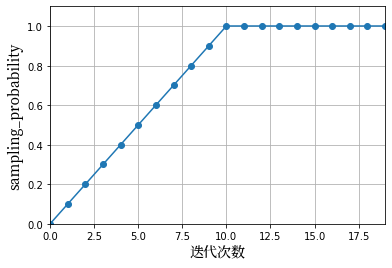

In [72]:
plt.plot(history.epoch, [min(1.0, epoch/(n_epochs-10)) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 1.1])
plt.xlabel("迭代次数", font_properties=my_font)
plt.ylabel("sampling_probability", font_properties=my_font)
plt.grid(True)
plt.show()

#### SampleEmbeddingSampler采样器

   对于推理，我们可以使用` GreedyEmbeddingSampler采样器`做与之前完全相同的事情。但是，为了完整起见，让我们改用 `SampleEmbeddingSampler采样器`。
    
   这几乎是一样的，只是它不是使用模型输出的 `argmax` 来查找令牌 ID，而是**将输出视为 `logits`，并使用随机采样的令牌 ID**。
    
   参数`softmax_temperature`: 参数值越高, 生成的文本越随机. 在计算 `softmax` 之前除以 `logits` 的值。较大的值（高于 1.0）会产生更多的随机样本，而较小的值会将采样分布推向 `argmax`。必须严格大于 0。默认为 1.0。

In [73]:
max_output_length = y_train.shape[1]  # 10
softmax_temperature = tf.Variable(1.)

# 解码器
inference_sampler = tfa.seq2seq.SampleEmbeddingSampler(
    embedding_fn=decoder_embedding_layer,
    softmax_temperature=softmax_temperature)

inference_decoder = tfa.seq2seq.basic_decoder.BasicDecoder(
    cell=decoder_cell,
    sampler=inference_sampler,
    output_layer=output_layer,
    maximum_iterations=max_output_length
)

In [74]:
batch_size = tf.shape(encoder_inputs)[:1]
start_tokens = tf.fill(dims=batch_size, value=sos_id)

final_outputs, final_state, final_sequence_lengths = inference_decoder(
    start_tokens,
    initial_state=encoder_state,
    start_tokens=start_tokens,
    end_token=0,
)

inference_model = keras.models.Model(inputs=[encoder_inputs],
                                     outputs=[final_outputs.sample_id])

In [75]:
def creative_predict_date_strs(date_strs, temperature=1.0):
    softmax_temperature.assign(temperature)
    X = prepare_date_strs_padded(date_strs)
    y_pred_ids = inference_model.predict(X)
    y_pred_str = ids_to_date_strs(y_pred_ids, output_chars)
    return y_pred_str

In [76]:
creative_predict_date_strs(["July 14, 1789", "May 19, 2022"])

['1789-07-14', '2022-05-19']

In [77]:
creative_predict_date_strs(["July 14, 1789", "May 19, 2022"],
                           temperature=5.)

['8189-42-28', '8002-06-11']

## 双向RNN Bidirectional RNNs

在有些任务中，一个时刻的输出不但和过去时刻的信息有关，**也和后续时刻的信息有关**。比如给定一个句子，其中一个词的词性由它的上下文决定，即包含左右两边的信息。因此，在这些任务中，我们可以**增加一个按照时间的逆序来传递信息的网络层，来增强网络的能力.**

`双向循环神经网络Bi-RNN`由两层循环神经网络组成，它们的输入相同，只是信息传递的方向不同.
   <img src="../images/other/16-7.png" width="400">

- 使用`keras`的`Bidirectional`层实现`双向RNN`

    详情:https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional

    - 参数`layer`: 它需要一个循环层（第一个 LSTM 层）作为参数
    - 参数`merge_mode`: 指定合并模式，该模式描述了在传递到下一层之前应该如何合并前向和后向输出。选项包括：
        - `sum`：结果相加
        - `mul`：结果相乘
        - `concat`（默认值）：将结果连接在一起，为下一层提供双倍的输出数量。
        - `ave`：取结果的平均值。

    - `Bidirectional`层会创建循环层(如`GRU`)的副本,但方向相反, 它将运行2个并合并它们的输出.因此尽管`GRU`层有10个单元, 但是`Bidirectional`层会在每个时间步长返回20个值.

In [78]:
model = keras.models.Sequential([
    keras.layers.GRU(10, return_sequences=True, input_shape=[None, 10]),
    keras.layers.Bidirectional(keras.layers.GRU(10, return_sequences=True))
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 10)          660       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 20)          1320      
Total params: 1,980
Trainable params: 1,980
Non-trainable params: 0
_________________________________________________________________


### Bi-LSTM

`双向 LSTM` 或 `Bi-LSTM` 是一种序列处理模型，由两个 `LSTM` 组成：一个在正向输入，另一个在反向输入。 `Bi-LSTM` 有效地增加了网络可用的信息量，改善了算法可用的上下文.

In [79]:
embedding_dim = 20
vocab_size = 87007

initialization(42)

bi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=vocab_size, output_dim=embedding_dim, name='embed-layer'
    ),  # Output Shape ==> (None_batch_size, None_each_input_length, output_dim=20)
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, name='lstm-layer'),
        name='bidir-lstm',  # 默认的merge_mode='concat' ==> (64)==>(128) 
    ),  # Output Shape ==> (None_batch_size, output_dim=128) 
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

bi_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed-layer (Embedding)      (None, None, 20)          1740140   
_________________________________________________________________
bidir-lstm (Bidirectional)   (None, 128)               43520     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,791,981
Trainable params: 1,791,981
Non-trainable params: 0
_________________________________________________________________


## 束搜索 Beam Search

### 贪心搜索和穷举搜索 Greedy Search and Exhaustive Search

- **贪心搜索**
    
    对输出序列的每一时间步$t'$, 基于`贪心搜索`找到具有**最高条件概率的词元**:
    $$\hat{x}_{t}=\underset{x \in \mathcal{V}}{\arg \max } p_{\theta}\left(x \mid \hat{\boldsymbol{x}}_{1:(t-1)}\right)$$
    一旦输出序列包含了`<eos>`或者达到其最大长度，则输出完成。
   <img src="../images/other/16-8.svg" width="200">
   
    这种贪婪式的搜索方式是次优的, 生成的序列 $\hat{x}_{1: T}$ 并不保证是全局最优的.
$$
\prod_{t=1}^{T} \max _{x_{t} \in V} p_{\theta}\left(x_{t} \mid \hat{x}_{1:(t-1)}\right) \leq \max _{x_{1: T} \in V^{r}} \prod_{t=1}^{T} p_{\theta}\left(x \mid \boldsymbol{x}_{1:(t-1)}\right) .
$$
    <img src="../images/other/16-9.svg" width="200">

- **穷举搜索**
    
    穷举搜索是穷举地列举**所有可能的输出序列及其条件概率**， 然后计算输出条件概率最高的一个。穷举搜索所选取序列的精度最高，但计算量最大。

### 束搜索 beam search

一种常用的减少搜索错误的启发式方法是`束搜索`:**在每一步中，生成$K$个最可能的前缀序列**，其中$K$为束的大小`Beam Size`.
<img src="../images/other/16-10.png" width="300">

束搜索的过程如下：在第1步时，生成$K$个最可能的词：在后面每一步中，从$K|v|$个候选输出中选择$K$个最可能的序列。

束的大小$K$越大，束搜索的复杂度越高，但越有可能生成最优序列，在实际应用中，束搜索可以通过调整束大小$K$来平衡计算复杂度和搜索质量之间的优先级。

束搜索通过灵活选择束宽，在正确率和计算代价之间进行权衡。

- 使用`TensorFlow-Addons`实现束搜索:
    - 首先创建一个`BeamSearchDecoder`,将所有解码器的副本包装起来
    - 为每个解码器副本创建一个解码器的最终状态副本, 并将这些状态连同开始令牌和结束令牌一起传递给解码器。

In [80]:
beam_width = 10

# 解码器
BeamSearch_decoder = tfa.seq2seq.beam_search_decoder.BeamSearchDecoder(
    cell=decoder_cell, beam_width=beam_width, output_layer=output_layer)

# tile_batch: 对tensor复制
decoder_init_state = tfa.seq2seq.beam_search_decoder.tile_batch(
    encoder_state, multiplier=beam_width)

In [81]:
# outputs, _, _ = BeamSearch_decoder(encoder_embeddings,
#                                    start_tokens=start_tokens,
#                                    end_token=0,
#                                    initial_state=decoder_init_state)

> Apotosome 05/01/22

# 注意力机制 Attention Mechanisms

## 笔记

<img src="../images/other/16-12.jpg">
<img src="../images/other/16-13.jpg">
<img src="../images/other/16-14.jpg">
<img src="../images/other/16-15.jpg">
<img src="../images/other/16-16.jpg">
<img src="../images/other/16-17.jpg">

---
- **基于注意力的序列到序列模型**
    <img src="../images/other/16-19.png" width="400">

    在基本的`Encoder-Decoder`模型中，注意力机制在`Encoder`和`Decoder`加入了上下文向量`context vector`，如上图所示，左边蓝色的代表`Encoder`，红色的代表`Decoder`。

    对于`Decoder`中每个要生成的$y$，都会生成一个上下文向量。这个上下文向量是由每个输入的`words`的信息加权求和得到的，其中权重向量就是**注意力向量**，它代表在此刻生成$y$时输入的单词的重要程度。最后将上下文向量和此刻的$y$的信息进行融合作为输出。

    构建上下文向量过程也很简单，首先对于一个固定的`target word`，我们把这个`target state`跟所有的`Encoder`的`state`进行比较，这样对每个`state`得到了一个`score`;然后使用`softmax`对这些`score`进行归一化，这样就得到了基于`target state`的条件概率分布。最后，对`source`的`state`进行加权求和，得到上下文向量，将上下文向量与`target state`融合作为最终的输出。

> $\begin{array}{rlr}\alpha_{t s} & =\frac{\exp \left(\operatorname{score}\left(\boldsymbol{h}_{t}, \overline{\boldsymbol{h}}_{s}\right)\right)}{\sum_{s^{\prime}=1}^{S} \exp \left(\operatorname{score}\left(\boldsymbol{h}_{t}, \overline{\boldsymbol{h}}_{s^{\prime}}\right)\right)} & \text { [Attention weights] (1)} 
\\ \boldsymbol{c}_{t} & =\sum_{s} \alpha_{t s} \overline{\boldsymbol{h}}_{s} & \text { [Context vector] (2)} 
\\ \boldsymbol{a}_{t} & =f\left(\boldsymbol{c}_{t}, \boldsymbol{h}_{t}\right)=\tanh \left(\boldsymbol{W}_{c}\left[\boldsymbol{c}_{t} ; \boldsymbol{h}_{t}\right]\right) & \text { [Attention vector] (3)}\end{array}$

- **`Bahdanau` 和 `Luong` 两种 `Attention` 机制**
<img src="../images/other/16-18.jpg" >

1. 注意力的计算方式不同

    - 在 `Luong Attention` 机制中，第 $t$ 步的注意力 $c_t$ 是由 `decoder` 第 $t$ 步的 `hidden state` $h_t$ 与 `encoder` 中的每一个 `hidden state` $\overline{\boldsymbol{h}}_{s}$ 加权计算得出的。
    - 在 `Bahdanau Attention` 机制中，第 $t$ 步的注意力 $c_t$ 是由 `decoder` 第 $t-1$ 步的 `hidden state` $h_{t-1}$  与 `encoder` 中的每一个 `hidden state`$\overline{\boldsymbol{h}}_{s}$ 加权计算得出的。
    
2. `decoder` 的输入输出不同
    - 在 `Bahdanau Attention` 机制中，`decoder` 在第 $t$ 步时，输入是由$c_t$与 $h_{t-1}$ **拼接**得出的，得到 $h_t$  并直接输出 $\hat y_{t+1}$ 。
    - 在 `Luong Attention` 机制在 `decoder` 部分**建立了一层额外的网络结构**，以注意力 $c_t$与原 `decoder` 第 t 步的 `hidden state` $h_t$**拼接**作为输入，得到第 t 步的 `hidden state` $\tilde{\mathbf{h}}_{t}$ 并输出 $\hat{\mathbf{y}}_{t}$ 。
    <img src="../images/other/16-20.png" width="300">
    
   总结一下, `Bahdanau Attention` 机制的计算流程为 $\mathbf{h}_{t-1} \rightarrow \mathbf{a}_{t} \rightarrow \mathbf{c}_{t} \rightarrow \mathbf{h}_{t}$, 而 `Luong attention` 机制的计算流程为 $\mathbf{h}_{t} \rightarrow \mathbf{a}_{t} \rightarrow \mathbf{c}_{t} \rightarrow \tilde{\mathbf{h}}_{t}$ 。
    
   相较而言, `Luong attention` 机制中的 `decoder` 在每一步使用当前步 (而非前一步) 的 `hidden state` 来计算注意力, 从逻辑上更自然, 但需要使用一层额外的 `RNN decoder` 来计算输出。
    
   此外, `Bahdanau Attention` 机制的论文中只尝试了使用 `concat` 作为对齐函数, 而 `Luong Attention` 机制 的论文在多种对齐函数上做了实验。


   - 根据计算区域的大小, 可以将对齐函数分为`全局注意力Global Attention `和`局部注意力Local Attention`两种机制。
       - 全局注意力模式会将 `encoder` 的每一步 `hidden state` 进行注意力计算
       - 局部注意力模式则计算部分范围的 `hidden state`。

   - 根据所用信息, 可以分为`基于内容的对齐`和`基于位置的对齐`。
       - 基于内容的对齐同时考虑了 `encoder` 的 `hidden state` $\overline{\mathbf{h}}_{s}$ 和当前步 `decoder` 的 `hidden state` $\mathbf{h}_{t}$
       - 基于位置的对齐只考虑当前步 `decoder` 的 `hidden state` $\mathbf{h}_{t}$ 。

> $\begin{aligned} \tilde{{h}}_{(t)} &=\sum_{i} \alpha_{(t, i)} {y}_{(i)} \\ \text { with } \alpha_{(t, i)} &=\frac{\exp \left(e_{(t, i)}\right)}{\sum_{i^{\prime}} \exp \left(e_{\left(t, i^{\prime}\right)}\right)} \\ \text { and } e_{(t, i)} &= \begin{cases}{h}_{(t)^{\top}} \mathbf{y}_{(i)} & \text { 点 } \\ {h}_{(t)^{\top}} {W}_{(i)} & \text { 普通 } \\ {v}^{\top} \tanh \left({W}\left[{h}_{(t)} ; {y}_{(i)}\right]\right) & \text { 合并 }\end{cases} \end{aligned}$

- 使用`tfa`将`Luong Attention`添加到编码器-解码器模型中

    我们简单地将解码器单元包装在一个注意力包装器中，并提供所需的注意力机制.

In [82]:
import tensorflow_addons as tfa

In [83]:
# attention_mechanism = tfa.seq2seq.attention_wrapper.LuongAttention(
#     units, encoder_state, memory_sequence_length=encoder_sequence_length)
# attention_decoder_cell = tfa.seq2seq.attention_wrapper.AttentionWrapper(
#     decoder_cell, attention_mechanism, attention_layer_size=n_units)

## 编码器-解码器示例

> 训练可以将日期字符串从一种格式转换为另一种格式的编码器-解码器模型
>
> 例如:从`April 22, 2019` 转换为 `2019-04-22`.

### V5: 使用 TF-Addons 的seq2seq , Keras 子类化 API 和注意力机制  Fifth version: using TFA seq2seq, the Keras subclassing API and attention mechanisms

这个问题中的序列很短，但如果我们想处理更长的序列，我们可能不得不使用`注意力机制`。虽然可以自己编写代码实现，但使用 `TF - Addons` 的实现更简单、更高效。现在让我们这样做，这次使用 `Keras` 的`子类化 API`。

警告：由于 `TensorFlow` 错误，`get_initial_state()`在`eager model`下失败，所以现在我们有使用`子类化 API`，因为 `Keras` 在 `call()` 方法上自动调用 `tf.function()` 。

1. 在此实现中，为简单起见，我们已恢复使用`TrainingSampler采样器`（但您可以轻松地对其进行调整以使用` ScheduledEmbeddingTrainingSampler采样器`）。我们还在推理过程中使用了`GreedyEmbeddingSampler采样器`，所以这个类非常容易使用.

    seq2seq之TensorFlow源码解析: https://zhuanlan.zhihu.com/p/52608602    

In [84]:
initialization(42)

In [85]:
class DateTranslation(keras.models.Model):
    def __init__(self, units=128, encoder_embedding_size=32, decoder_embedding_size=32, **kwargs):
        super(DateTranslation, self).__init__(**kwargs)

        # 编码器
        self.encoder_embedding = keras.layers.Embedding(input_dim=encoder_inputs_dim,
                                                        output_dim=encoder_embedding_size)
        self.encoder = keras.layers.LSTM(units,
                                         return_sequences=True,
                                         return_state=True)
        # 解码器
        self.decoder_embedding = keras.layers.Embedding(input_dim=decoder_inputs_dim,
                                                        output_dim=decoder_embedding_size)
        self.attention = tfa.seq2seq.LuongAttention(units)

        # LSTMCell()作为在推理过程中，我们使用一步输出作为下一步输入
        decoder_inner_cell = keras.layers.LSTMCell(units)
        self.decoder_cell = tfa.seq2seq.AttentionWrapper(cell=decoder_inner_cell,
                                                         attention_mechanism=self.attention)
        # 训练过程中使用了TrainingSampler采样器
        training_sampler = tfa.seq2seq.sampler.TrainingSampler()
        output_layer = keras.layers.Dense(decoder_outputs_dim)

        self.decoder = tfa.seq2seq.BasicDecoder(cell=self.decoder_cell,
                                                sampler=training_sampler,
                                                output_layer=output_layer)

        # 推理过程中使用了GreedyEmbeddingSampler采样器
        inference_sampler = tfa.seq2seq.sampler.GreedyEmbeddingSampler(
            embedding_fn=self.decoder_embedding
        )
        self.inference_decoder = tfa.seq2seq.BasicDecoder(cell=self.decoder_cell,
                                                          sampler=inference_sampler,
                                                          output_layer=output_layer,
                                                          maximum_iterations=max_output_length)  # 最大迭代次数

    def call(self, inputs, training=None):
        # encoder_inputs = keras.layers.Input( shape=[None], dtype=np.int32 )
        # decoder_inputs = keras.layers.Input( shape=[None], dtype=np.int32 )
        encoder_input, decoder_input = inputs
        # 编码器
        encoder_embeddings = self.encoder_embedding(encoder_input)
        encoder_outputs, encoder_state_h, encoder_state_c = self.encoder(encoder_embeddings,
                                                                         training=training)
        encoder_state = [encoder_state_h, encoder_state_c]  # 最后一个时间步的状态

        self.attention(encoder_outputs, setup_memory=True)
        # LuongAttention要求在每个时间步，两个向量必须具有相同的维度

        # 解码器
        decoder_embeddings = self.decoder_embedding(decoder_input)
        decoder_initial_state = self.decoder_cell.get_initial_state(decoder_embeddings)  # 生成零填充的状态
        decoder_initial_state = decoder_initial_state.clone(cell_state=encoder_state)

        if training:
            decoder_outputs, _, _ = self.decoder(decoder_embeddings,
                                                 initial_state=decoder_initial_state,
                                                 training=training)
            # 比 keras.layers.Activation( "softmax" )( decoder_outputs.rnn_output ) 快
            y_prob = tf.nn.softmax(decoder_outputs.rnn_output)
        else:
            start_tokens = tf.zeros_like(encoder_input[:, 0]) + sos_id
            decoder_outputs, _, _ = self.inference_decoder(decoder_embeddings,
                                                           initial_state=decoder_initial_state,
                                                           start_tokens=start_tokens,
                                                           end_token=0)
            y_prob = tf.nn.softmax(decoder_outputs.rnn_output)
        return y_prob

In [86]:
model = DateTranslation()
optimizer = keras.optimizers.Nadam()
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=optimizer,
              metrics=[keras.metrics.sparse_categorical_accuracy])
history = model.fit([X_train, X_train_decoder], y_train,
                    epochs=25,
                    validation_data=([X_val, X_val_decoder], y_val))

Epoch 1/25


2022-05-19 13:26:39.845023: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla P100-PCIE-16GB" frequency: 1328 num_cores: 56 environment { key: "architecture" value: "6.0" } environment { key: "cuda" value: "11000" } environment { key: "cudnn" value: "8005" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 16152002560 bandwidth: 732160000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


313/313 [==============================] - ETA: 0s - loss: 2.1669 - sparse_categorical_accuracy: 0.2237

2022-05-19 13:27:02.965100: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla P100-PCIE-16GB" frequency: 1328 num_cores: 56 environment { key: "architecture" value: "6.0" } environment { key: "cuda" value: "11000" } environment { key: "cudnn" value: "8005" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 16152002560 bandwidth: 732160000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


313/313 [==============================] - 32s 77ms/step - loss: 2.1669 - sparse_categorical_accuracy: 0.2237 - val_loss: 2.1335 - val_sparse_categorical_accuracy: 0.2353
Epoch 2/25
313/313 [==============================] - 22s 69ms/step - loss: 2.0146 - sparse_categorical_accuracy: 0.2807 - val_loss: 1.5630 - val_sparse_categorical_accuracy: 0.4298
Epoch 3/25
313/313 [==============================] - 30s 95ms/step - loss: 1.3413 - sparse_categorical_accuracy: 0.5120 - val_loss: 1.2269 - val_sparse_categorical_accuracy: 0.5515
Epoch 4/25
313/313 [==============================] - 23s 74ms/step - loss: 1.1129 - sparse_categorical_accuracy: 0.5931 - val_loss: 0.9948 - val_sparse_categorical_accuracy: 0.6308
Epoch 5/25
313/313 [==============================] - 22s 71ms/step - loss: 0.8341 - sparse_categorical_accuracy: 0.6828 - val_loss: 0.7280 - val_sparse_categorical_accuracy: 0.7337
Epoch 6/25
313/313 [==============================] - 22s 71ms/step - loss: 0.3622 - sparse_categoric

这次收敛需要更长的时间，但每次迭代也有更多的参数和更多的计算。而且我们没有使用`ScheduledEmbeddingTrainingSampler采样器`。

2. 现在我们可以编写一个简单的函数，使用训练好的模型来执行日期格式转换

In [87]:
def fast_pred_date_strs_v2(date_strs):
    X = prepare_date_strs_padded(date_strs)
    X_decoder = tf.zeros(shape=(len(X), max_output_length), dtype=tf.int32)    # shape:(18, 10)
    y_prob = model.predict([X, X_decoder])
    y_pred = tf.argmax(y_prob, axis=-1)
    y_pred_str = ids_to_date_strs(y_pred, output_chars)
    return y_pred_str

In [100]:
fast_pred_date_strs_v2(["July 14, 1789", "May 19, 2022"])

2022-05-19 13:47:55.333022: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla P100-PCIE-16GB" frequency: 1328 num_cores: 56 environment { key: "architecture" value: "6.0" } environment { key: "cuda" value: "11000" } environment { key: "cudnn" value: "8005" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 16152002560 bandwidth: 732160000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


['1789-07-14', '2022-05-19']

`TF-Addons` 仍有一些有趣的功能，您可能想看看：
- 使用`BeamSearchDecoder`而不是`BasicDecoder`进行推理。这个解码器不是输出概率最高的字符，而是跟踪几个候选者，并且只保留最可能的候选者序列。
- 如果输入或目标序列的长度可能非常不同，则设置掩码或指定`sequence_length`。
- 使用 `ScheduledOutputTrainingSampler`，它比 `ScheduledEmbeddingTrainingSampler` 决定如何在时间 $t$ 将输出馈送到时间$t+1$ 的单元格,提供了更大的灵活性。默认情况下，它将输出直接提供给单元，而不计算 argmax ID 并将其传递给嵌入层。或者，您指定一个 `next_inputs_fn` 函数，该函数将用于在下一步将单元格输出转换为输入。

# Transformer 架构- TensorFlow实现

## 笔记

<img src="../images/other/16-21.jpg">
<img src="../images/other/16-22.jpg">

## 原理

<img src="../images/other/16-23.svg" width="400px">

- 左侧是`编码器`:
    - 将一批表示为单词 I D 的序列的句子作为输入，输入形状为 `[batch_size,  max_input_sentence_length]`.
    - 并将每个单词编码为 512 维表示, 因此编码器的输出形状是`[batch_size,  max_input_sentence_length, 512]`.
    - 请注意，编码器的顶部堆叠了 N 次(在论文中，N = 6).
- 右侧是`解码器`:
    - 在训练期间，它将目标句子作为输入（也表示为单词 ID 的序列），向右移动一个时间步长, 在开头插入序列的开始标记。它还接收编码器的输出。
    - 请注意，解码器的顶部也堆叠了 N 次，并且编码器堆栈的最终输出在这 N 层中的每一层都被馈送到解码器。
    - 解码器在每个时间步为每个可能的下一个单词输出一个概率, 它的输出形状是 `[batch_size, max_output_sentence_length, vocabulary_length]`.
- 在推理过程中，无法为解码器提供目标值，因此我们向其提供先前输出的单词, 以序列开始标记开始。因此, 需要模型被重复调用，每轮预测一个单词, 直到输出序列结束标记.
- 2个嵌入层; 5 × N 个跳过连接，每个连接后跟一个规范化层; 2 × N逐位前馈网络，每个模块由 2 个密集层组成（第一个使用 `Re LU` 激活函数，第二个没有激活函数），以及最后输出层是使用`softmax`激活函数的密集层。
所有这些层都是时间分布的，因此每个单词都独立于所有其他单词来处理。

- `编码器`的 `多头注意力` 层对同一句子中每个单词与其他单词的关系进行编码，更加关注最相关的单词。这种注意力机制称为`self-attention`（句子正在关注自身）。
- `解码器`的 `掩蔽多头注意力` 层做同样的事情，但每个词只允许关注位于它之前的词。`解码器`的上层 `多头注意力` 层是解码器关注输入句子中单词的地方。

- `位置嵌入`只是表示单词在句子中位置的密集向量。位置嵌入被添加到每个句子中单词的词嵌入中。

### 位置嵌入 Positional embeddings

> 正弦/余弦位置嵌入:
> \begin{split}\begin{aligned} P_{p, 2i} &= \sin\left(\frac{p}{10000^{2i/d}}\right)\\P_{p, 2i+1} &= \cos\left(\frac{p}{10000^{2i/d}}\right)\end{aligned}\end{split}
>
> 其中$P_{p, i}$是位于句子中第$p$个位置的单词的嵌入的第$i$个分量.

In [89]:
class PositionalEncoding(keras.layers.Layer):

    def __init__(self, max_steps, max_dims, dtype=tf.float32, **kwargs):
        """
        :param max_steps: 最大的句子长度
        :param max_dim: 每个单词所表示的维度 这里是512维
        """
        super(PositionalEncoding, self).__init__(dtype=dtype, **kwargs)
        if max_dims % 2 == 1:
            max_dims += 1  # max_dim 必须是偶数

        #  P𝑝,𝑖 是位于句子中第 𝑝 个位置的单词的嵌入的第 𝑖 个分量.
        p, i = np.meshgrid(np.arange(max_steps), np.arange(max_dims // 2))

        # (batch_size, number of time steps or sequence length, dimensions)
        pos_embed = np.empty((1, max_steps, max_dims))
        # np.sin().shape -> (i,p)  => .T -> (p,i)
        pos_embed[0, :, ::2] = np.sin(p / 10000**(2 * i / max_dims)).T
        pos_embed[0, :, 1::2] = np.cos(p / 10000**(2 * i / max_dims)).T

        self.position_embedding = tf.constant(pos_embed.astype(self.dtype))

    def call(self, inputs, *args, **kwargs):
        # inputs=np.zeros( (1, max_steps, max_dims), np.float32)
        shape = tf.shape(inputs)
        return inputs + self.position_embedding[:, :shape[-2], :shape[-1]]

- 绘制示意图

In [90]:
max_steps = 201
max_dims = 512
pos_embed = PositionalEncoding(max_steps, max_dims)
PE = pos_embed(np.zeros((1, max_steps, max_dims), np.float32))[0].numpy()

In [91]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

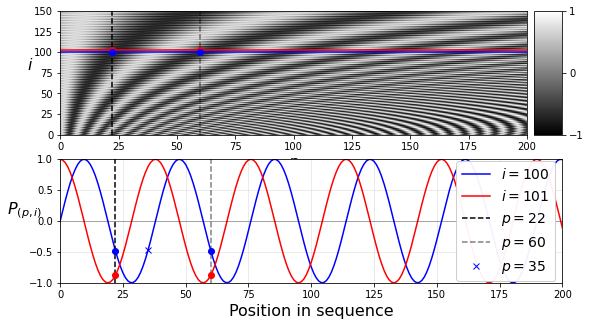

In [92]:
i1, i2, crop_i = 100, 101, 150  # 裁切分量至150
p1, p2, p3 = 22, 60, 35
fig, (ax2, ax1) = plt.subplots(
    nrows=2,
    ncols=1,  # sharex=True, 
    figsize=(9, 5))

#########
im = ax2.imshow(PE.T[:crop_i],
                cmap="gray",
                interpolation="bilinear",
                aspect="auto")
ax2.hlines(y=i1, xmin=0, xmax=max_steps - 1, color="b")  # 绘制水平线
cheat = 2  # 需要将红线抬高一点，否则会隐藏蓝线
ax2.hlines(i2 + cheat, 0, max_steps - 1, color="r")

ax2.plot([p1, p1], [0, crop_i], "k--")
ax2.plot([p2, p2], [0, crop_i], "k--", alpha=0.5)
ax2.plot([p1, p2], [i2 + cheat, i2 + cheat], "ro")
ax2.plot([p1, p2], [i1, i1], "bo")

ax2.axis([0, max_steps - 1, 0, crop_i])
ax2.set_xlabel("$p$", fontsize=16)
ax2.set_ylabel("$i$", rotation=0, fontsize=16)
#########
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='6%', pad=0.1)
cb = fig.colorbar(im, cax=cax, orientation="vertical")
cb.set_ticks([-1, 0, 1])
cb.update_ticks()
#########
ax1.plot(PE[:, i1], "b-", label="$i = {}$".format(i1))
ax1.plot(PE[:, i2], "r-", label="$i = {}$".format(i2))

ax1.plot([p1, p1], [-1, 1], "k--", label="$p = {}$".format(p1))
ax1.plot([p2, p2], [-1, 1], "k--", label="$p = {}$".format(p2), alpha=0.5)
ax1.plot(p3, PE[p3, i1], "bx", label="$p = {}$".format(p3))

ax1.plot([p1, p2], [PE[p1, i1], PE[p2, i1]], "bo")
ax1.plot([p1, p2], [PE[p1, i2], PE[p2, i2]], "ro")

ax1.legend(loc="center right", fontsize=14, framealpha=0.95)
ax1.set_ylabel("$P_{(p,i)}$", rotation=0, fontsize=16)

ax1.grid(True, alpha=0.3)
ax1.hlines(0, 0, max_steps - 1, color="k", linewidth=1, alpha=0.3)
ax1.axis([0, max_steps - 1, -1, 1])
ax1.set_xlabel( "Position in sequence", fontsize=16)

plt.show()

- 接下来,创建`Transformer`的第一层:

In [93]:
embed_size = 512
max_steps = 500
vocab_size = 10000

In [94]:
embeddings = keras.layers.Embedding(vocab_size, embed_size)
position_encoding = PositionalEncoding(max_steps=max_steps,
                                       max_dims=embed_size)

# 编码器
encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
encoder_embeddings = embeddings(encoder_inputs)
encoder_in = position_encoding(encoder_embeddings)

# 解码器
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_embeddings = embeddings(decoder_inputs)
decoder_in = position_encoding(decoder_embeddings)

### 缩放点积注意力 Scaled Dot-Product Attention

> 缩放点积注意力:
> $$\operatorname{Attention}(\mathbf{Q}, \mathbf{K}, \mathbf{V})=\operatorname{softmax}\left(\frac{\mathbf{Q} \mathbf{K}^{\top}}{\sqrt{d_{k e y s}}}\right) \mathbf{V}$$

- 在`编码器`中，这个等式应用于批处理中的**每个输入句子**，其中$Q$、$K$和$V$都等于输入句子中的单词列表`(Embeddings+Positional Embeddings)`,因此句子中的每个单词都会进行比较同一句子中的每个单词，包括它自己。
- 在`解码器`的 `masked attention` 层中，等式将应用于批处理中的**每个目标句子**，其中 $Q$、$K$和$V$都等于目标句子中的单词列表，但这次使用了掩码来防止任何单词与位于它之后的单词进行比较(在推理时，解码器只能访问它已经输出的单词，而不是将来的单词，因此在训练期间我们必须屏蔽未来的输出令牌)。
- 在`解码器`的注意力层上部，键 $K$ 和值 $V$ 只是`编码器`生成的单词编码列表，查询 $Q$ 是`解码器`生成的单词编码列表。

> 在TensorFlow中，如果 $A$ 和 $B$ 是具有两个以上维度的张量(例如，形状分别为 `[2, 3, 4, 5]` 和 `[2, 3, 5, 6]`)，则 `tf.matmul(A, B)`会将这些张量视为 2 × 3 数组，其中每个单元都包含一个矩阵，并将相应的矩阵相乘：
>
> $A$ 中的第$i$行和第$j$列的矩阵将乘以 $B$ 中的第$i$行和第$j$列的矩阵。
>
> 一个 4 × 5 矩阵和一个 5 × 6 矩阵是一个 4 × 6 矩阵，`tf.matmul(A, B)` 将返回一个形状为 `[2, 3, 4, 6]` 的数组。

- `Kears`中的`kears.layers.Attention`层实现缩放点积注意力
    - `use_scale=True`: 创建一个附加参数, 让层学习如何正确缩小相似度分数, 而不是`transformer`中固定的因子${\sqrt{d_{k e y s}}}$来降低相似度分数.
    - `causal=True`: 可确保每个输出令牌仅注意先前的输出令牌, 而不是将来的.

- 这是一个简化的 `Transformer`（实际架构有跳过连接、层范数、密集网络，最重要的是它使用 Multi-Head Attention 而不是常规 Attention）

In [95]:
# 编码器
# encoder_in = position_encoding(encoder_embeddings)
Z = encoder_in

for N in range(6):
    # input:( [query_seq_encoding, value_seq_encoding])
    Z = keras.layers.Attention(use_scale=True)([Z, Z])
encoder_outputs = Z

In [96]:
# 解码器
# decoder_in = position_encoding(decoder_embeddings)
Z = decoder_in
for N in range(6):
    Z = keras.layers.Attention(use_scale=True, causal=True)([Z, Z])
    Z = keras.layers.Attention(use_scale=True)([Z, encoder_outputs])

outputs = keras.layers.TimeDistributed(
    keras.layers.Dense(vocab_size, activation="softmax"))(Z)

### 多头注意力 Multi-Head Attention

<img src="../images/other/16-24.png" width="200">
<img src="../images/other/16-25.png">

嵌入的不同部分可以学习每个单词含义的不同方面，因为它与序列中的其他单词相关。这允许 `Transformer` 捕获对序列的更丰富的解释。
<img src="../images/other/16-55.png">

> 小结:
> 1. `__init__`主要用来做参数初始化用，比如我们要初始化卷积的一些参数，就可以放到这里面
> 2. `call`可以把类型的对象当做函数来使用，这个对象可以是在`__init__`里面也可以是在`build`里面
> 3. `build`一般是和`call`搭配使用，这个时候，它的功能和`__init__`很相似，当`build`中存放本层需要初始化的变量，当`call`被第一次调用的时候，会先执行`build()`方法初始化变量，但后面再调用到`call`的时候，是不会再去执行`build()`方法初始化变量

请注意，具有 `kernel_size=1`, 并且默认 `padding="valid"` 和 `strides=1`的 `Conv1D` 层等效于 `Time Distributed(Dense(...))` 层.

In [97]:
K = keras.backend

In [98]:
class MultiHeadAttention(keras.layers.Layer):

    def __init__(self, n_heads, use_scale=False, causal=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.n_heads = n_heads
        self.use_scale = use_scale
        self.causal = causal

    def build(self, batch_input_shape):
        super(MultiHeadAttention, self).build(batch_input_shape)
        self.dims = batch_input_shape[0][-1]  # 512
        # 使用8个头 --> d_k = d_v = d_model/h = 64.
        self.q_dims, self.v_dims, self.k_dims = [self.dims // self.n_heads] * 3

        # 线性层
        self.q_linear = keras.layers.Conv1D(
            filters=self.n_heads * self.q_dims,  # Embedding_dim
            kernel_size=1,  # 默认 stride=1, padding="valid"
            use_bias=False)
        self.v_linear = keras.layers.Conv1D(filters=self.n_heads * self.v_dims,
                                            kernel_size=1,
                                            use_bias=False)
        self.k_linear = keras.layers.Conv1D(filters=self.n_heads * self.k_dims,
                                            kernel_size=1,
                                            use_bias=False)

        self.attention = keras.layers.Attention(causal=self.causal,
                                                use_scale=self.use_scale)
        self.out_linear = keras.layers.Conv1D(self.dims,
                                              kernel_size=1,
                                              use_bias=False)

    def _multi_head_linear(self, inputs, linear):
        shape = K.concatenate([
            K.shape(inputs)[:-1],  # 除了dims
            [self.n_heads, -1]
        ])  # [n_heads, q_dims OR v_dims OR k_dims]

        projected = K.reshape(linear(inputs), shape)  # 展平
        #  (Batch_size, n_Sequence, n_heads, q_dims OR v_dims OR k_dims)
        # 交换头部和序列维度
        perm = K.permute_dimensions(projected, pattern=[0, 2, 1, 3])
        #  (Batch_size, n_heads, n_Sequence, q_dims OR v_dims OR k_dims)

        # 由于 tf.keras 只支持 3D 计算
        #  (Batch_size * n_heads, n_Sequence, q_dims OR v_dims OR k_dims)
        return K.reshape(perm, [shape[0] * self.n_heads, shape[1], -1])

    def call(self, inputs, *args, **kwargs):
        q = inputs[0]
        v = inputs[1]
        k = inputs[3] if len(inputs) > 2 else v
        shape = K.shape(q)

        q_proj = self._multi_head_linear(q, self.q_linear)
        v_proj = self._multi_head_linear(v, self.v_linear)
        k_proj = self._multi_head_linear(k, self.k_linear)
        #  (Batch_size * n_heads, n_Sequence, q_dims OR v_dims OR k_dims)
        multi_attended = self.attention([q_proj, v_proj, k_proj])

        shape_attended = K.shape(multi_attended)
        reshaped_attended = K.reshape(
            multi_attended,
            # Batch_size, n_heads,   n_Sequence,       q_dims or Query size
            [shape[0], self.n_heads, shape_attended[1], shape_attended[2]])
        # 将每个头的注意力分数合并在一起
        # 交换头部和序列维度
        perm = K.permute_dimensions(reshaped_attended, [0, 2, 1, 3])
        concat = K.reshape(perm, [shape[0], shape_attended[1], -1])
        return self.out_linear(concat)

In [99]:
Q = np.random.rand(2, 50, 512)
V = np.random.rand(2, 80, 512)
multi_attn = MultiHeadAttention(8)  #n_heads=8
multi_attn([Q, V]).shape

TensorShape([2, 50, 512])

> create:Apotosome 05/19/22

> update:Apotosome 10/26/22